In [1]:
%%time
import matplotlib
from marss2l.utils import setup_stream_logger, get_remote_filesystem
import logging

logger = logging.getLogger(__name__)
setup_stream_logger(logger)

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

C0 = "#648FFF"
C1 = "#785EF0"
C2 = "#DC267F"
C3 = "#FE6100"
C4 = "#FFB000" # #FFB000

import os

fs = get_remote_filesystem()
os.makedirs("figures", exist_ok=True)

Using account key
CPU times: user 1.73 s, sys: 1.85 s, total: 3.58 s
Wall time: 1.56 s


In [2]:
%%time 

from marss2l import loaders

LOCS_TRAINING_IN_DISTRIBUTION = loaders.LOCS_TRAINING_ABLATION
csv_path = "az://public/MARS-S2L/dataset_20250609/validated_images_all.csv"
dataframe_data_traintest = loaders.read_csv(csv_path, 
                                            add_columns_for_analysis=True, 
                                            fs=fs, split="all", add_case_study=True, 
                                            add_loc_type=True)
dataframe_data_traintest["country"] = dataframe_data_traintest.apply(lambda row: "Offshore" if row.offshore else row.country, 
                                                                     axis=1)

CPU times: user 48 s, sys: 2.57 s, total: 50.6 s
Wall time: 1min 52s


In [3]:
# Count number of images with more than one plume
# from shapely import wkt
# import geopandas as gpd
# geometries = dataframe_data_traintest.plume.apply(wkt.loads)
# dataframe_data_traintest["nplumes"] = geometries.apply(lambda geom: 0 if geom.is_empty else len(geom.geoms))
# dataframe_data_traintest.nplumes.value_counts()

In [4]:
dataframe_data_traintest = dataframe_data_traintest[~dataframe_data_traintest.location_name.isin(loaders.LOCATIONS_CONTROL_RELEASES)].copy()
rename_splits = {"test_2023": "test", "train_2023": "train", "val_2023": "val"}
dataframe_data_traintest["split_name"] = dataframe_data_traintest["split_name"].apply(lambda x: rename_splits[x] if x in rename_splits else x)

In [5]:
nplumes_total = dataframe_data_traintest.loc[dataframe_data_traintest.split_name.isin(["train","val","test"]),"isplume"].sum()
nimages_total = dataframe_data_traintest.loc[dataframe_data_traintest.split_name.isin(["train","val","test"])].shape[0]
nlocs_total = dataframe_data_traintest.location_name.nunique()
print(f"In total {nimages_total} images containing {nplumes_total} emissions over {nlocs_total} distinct emitters")

In total 87929 images containing 5534 emissions over 1315 distinct emitters


In [6]:
images_by_yearmonth = dataframe_data_traintest.groupby(["country","year_month"])["isplume"].agg(["count","sum"]).rename({"count": "# images", "sum": "# plumes"}, axis=1)
images_by_yearmonth["# locs"] = dataframe_data_traintest.groupby(["country","year_month"])["location_name"].nunique()
images_by_yearmonth = images_by_yearmonth.reset_index()
images_by_yearmonth

,country,year_month,# images,# plumes,# locs
0,Algeria,2013-03-01,1,0,1
1,Algeria,2013-04-01,1,0,1
2,Algeria,2013-06-01,2,0,1
3,Algeria,2013-08-01,1,1,1
4,Algeria,2013-09-01,1,1,1
...,...,...,...,...,...
1250,Yemen,2024-08-01,23,2,3
1251,Yemen,2024-09-01,31,8,3
1252,Yemen,2024-10-01,32,11,3
1253,Yemen,2024-11-01,28,14,3


In [7]:
images_by_yearmonth_casestudy = dataframe_data_traintest.groupby(["case_study","year_month"])["isplume"].agg(["count","sum"]).rename({"count": "# images", "sum": "# plumes"}, axis=1)
images_by_yearmonth_casestudy["# locs"] = dataframe_data_traintest.groupby(["case_study","year_month"])["location_name"].nunique()
images_by_yearmonth_casestudy = images_by_yearmonth_casestudy.reset_index()
images_by_yearmonth_casestudy

,case_study,year_month,# images,# plumes,# locs
0,Algeria,2013-03-01,1,0,1
1,Algeria,2013-04-01,1,0,1
2,Algeria,2013-06-01,2,0,1
3,Algeria,2013-08-01,1,1,1
4,Algeria,2013-09-01,1,1,1
...,...,...,...,...,...
869,Venezuela,2024-08-01,3,0,2
870,Venezuela,2024-09-01,2,0,2
871,Venezuela,2024-10-01,4,1,2
872,Venezuela,2024-11-01,14,1,4


## Time series total number of images for Figure 1b

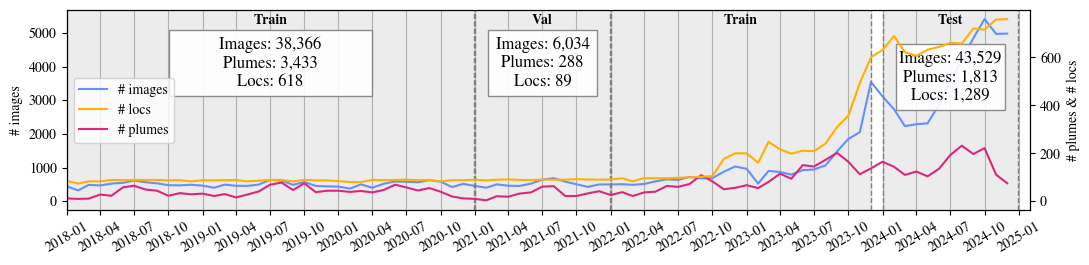

In [8]:
from marss2l.plot import images_by_month
from importlib import reload
import matplotlib.pyplot as plt
from datetime import datetime
reload(images_by_month)

fig, ax = plt.subplots(1, 1, figsize=(11, 2.75))
images_by_month.plot_images_by_month(dataframe_data_traintest, ax, datetime(2018, 1, 1),
                                    step_in_months=3,
                                    datetime_end=datetime(2025, 2, 1))

plt.tight_layout()
plt.savefig("figures/fig1_ts_images_detections.pdf")

In [9]:
import pandas as pd
pd.set_option('display.max_rows', 300)

## Number of images in case studies

### All data

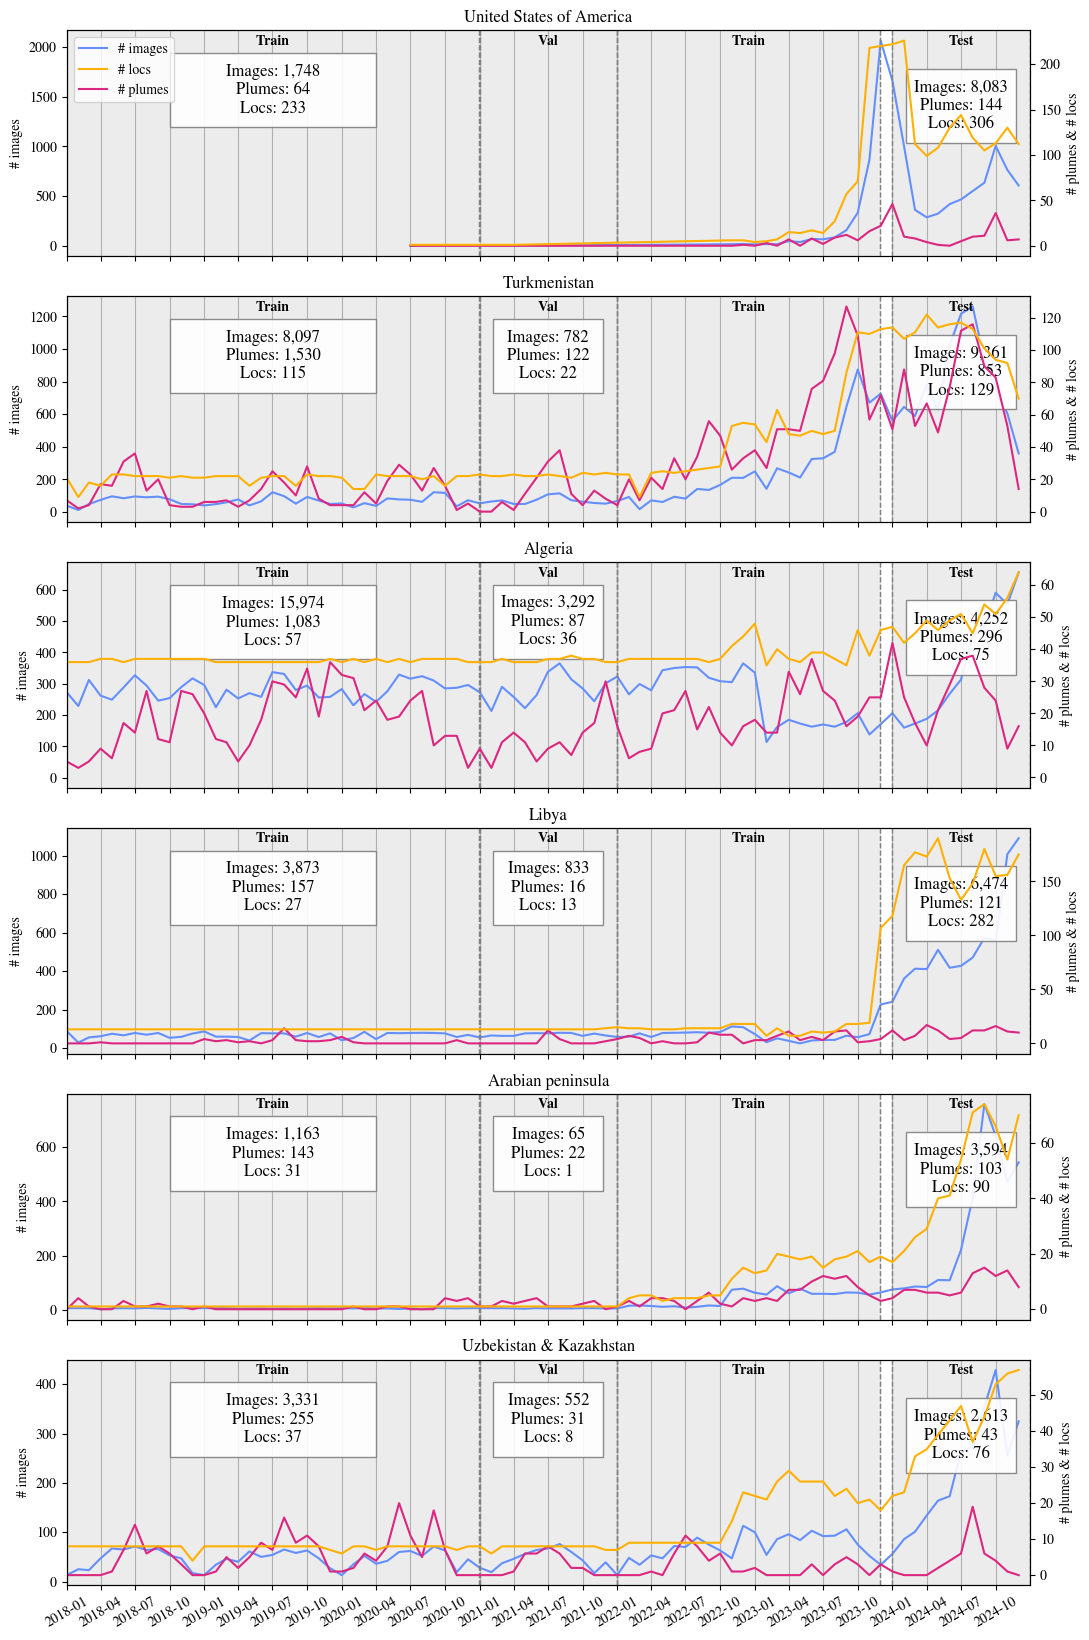

In [10]:
case_studies_plot = loaders.ORDER_CASE_STUDIES[:6]

ncountries = len(case_studies_plot)
fig, ax = plt.subplots(ncountries,1, figsize=(11, ncountries*2.75), sharex=True, tight_layout=True)

for i, country in enumerate(case_studies_plot):
    df_plot = dataframe_data_traintest[dataframe_data_traintest.case_study == country]
    images_by_month.plot_images_by_month(df_plot, ax=ax[i],
                                         loc_legend="upper left", 
                                         plot_legend=  i == 0,
                                         datetime_start=datetime(2018,1,1),
                                         datetime_end=datetime(2025,1,1))
    ax[i].set_title(country)

plt.savefig("figures/fig1_ts_images_detections_by_country_1.pdf")

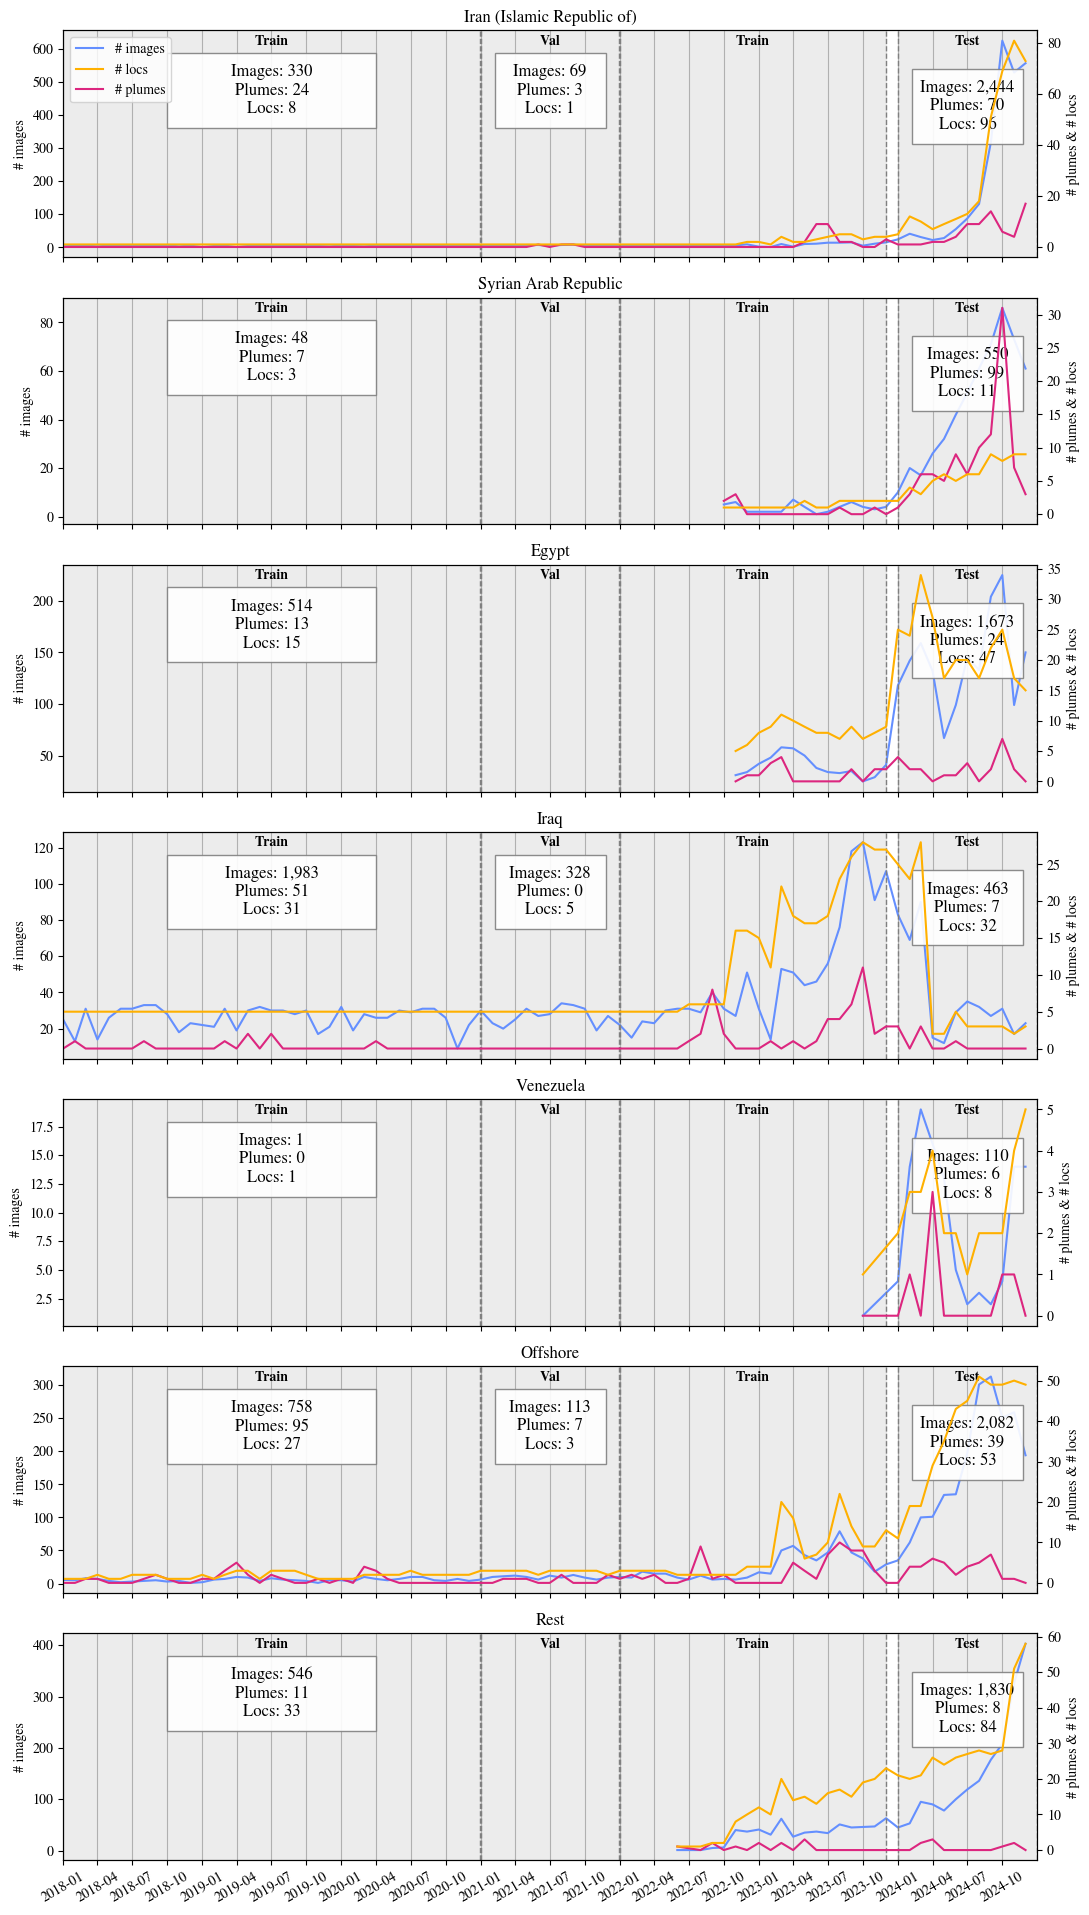

In [11]:
case_studies_plot = loaders.ORDER_CASE_STUDIES[6:]

ncountries = len(case_studies_plot)
fig, ax = plt.subplots(ncountries,1, figsize=(11, ncountries*2.75), sharex=True, tight_layout=True)

for i, country in enumerate(case_studies_plot):
    df_plot = dataframe_data_traintest[dataframe_data_traintest.case_study == country]
    images_by_month.plot_images_by_month(df_plot, ax=ax[i],
                                         loc_legend="upper left", 
                                         plot_legend= i == 0,
                                         datetime_start=datetime(2018,1,1),
                                         datetime_end=datetime(2025,1,1))
    ax[i].set_title(country)
plt.savefig("figures/fig1_ts_images_detections_by_country_2.pdf")

## Distribution of test data by case study

/tmp/ipykernel_86918/1239688717.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2iter.set_xticklabels(ax2iter.get_xticklabels(), rotation=30)
/tmp/ipykernel_86918/1239688717.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2iter.set_xticklabels(ax2iter.get_xticklabels(), rotation=30)
/tmp/ipykernel_86918/1239688717.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2iter.set_xticklabels(ax2iter.get_xticklabels(), rotation=30)
/tmp/ipykernel_86918/1239688717.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2iter.set_xticklabels(ax2iter.get_xticklabels(), rotation=30)
/tmp/ipykernel_86918/1239688717.py:36: UserWarning: set_ticklabels()

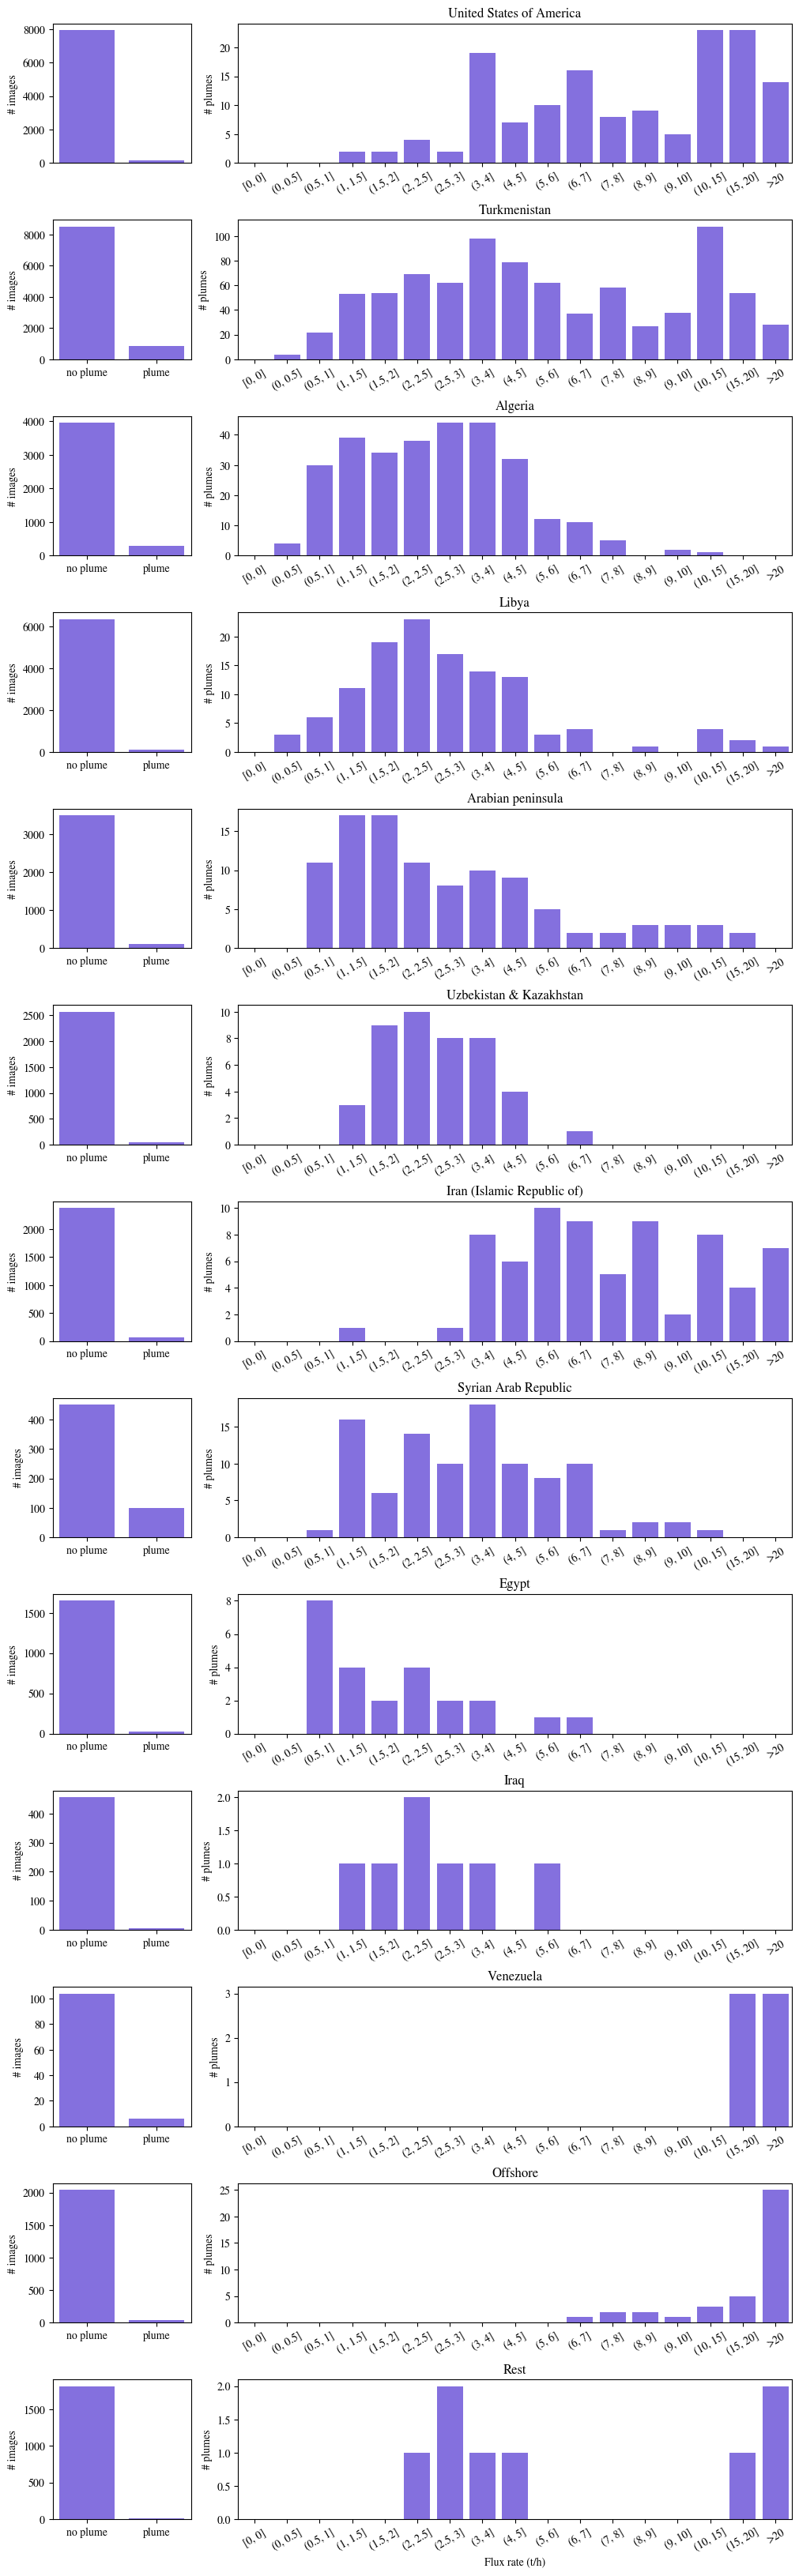

In [12]:
from matplotlib import gridspec
import seaborn as sns

# Create a figure with a specified size
fig = plt.figure(figsize=(10,2.5*len(loaders.ORDER_CASE_STUDIES)), 
                 layout="constrained")

# Create a GridSpec with 2 rows and 2 columns, specifying the width ratios
gs = gridspec.GridSpec(len(loaders.ORDER_CASE_STUDIES), 2, 
                       width_ratios=[1, 4], figure=fig)

# Create subplots using the GridSpec and share the x-axis between specific subplots
ax1 = fig.add_subplot(gs[0, 0])  # Narrower subplot
ax2 = fig.add_subplot(gs[0, 1])  # Wider subplot


for i, country in enumerate(loaders.ORDER_CASE_STUDIES):
    df_plot_hist_fluxrate = dataframe_data_traintest[(dataframe_data_traintest.split_name == "test")  & (dataframe_data_traintest.case_study == country)]
    if i == 0:
        ax1iter = ax1
        ax2iter = ax2
    else:
        ax1iter = fig.add_subplot(gs[i, 0], sharex=ax1)  # Narrower subplot, sharing x-axis with ax1
        ax2iter = fig.add_subplot(gs[i, 1], sharex=ax2)  # Wider subplot, sharing x-axis with ax2
        
    sns.countplot(data=df_plot_hist_fluxrate[df_plot_hist_fluxrate.isplume], 
                  x="interval_ch4_fluxrate_str", ax=ax2iter,color=C1)
    sns.countplot(data=df_plot_hist_fluxrate, x="isplume", ax=ax1iter,color=C1)
    ax1iter.set_ylabel("# images")
    ax2iter.set_ylabel("# plumes")
    ax2iter.set_title(country)
    # if i != len(loaders.ORDER_CASE_STUDIES) -1:
        # ax2iter.xaxis.set_visible(False)
    #    ax1iter.xaxis.set_visible(False)
    # ax2iter.grid(axis="x")
    ax2iter.set_xticklabels(ax2iter.get_xticklabels(), rotation=30)
    ax2iter.set_xlabel("")
    ax1iter.set_xlabel("")

plt.xticks(rotation=30)

ax1.xaxis.set_visible(False)
# ax2.xaxis.set_visible(False)

ax2iter.set_xlabel("Flux rate (t/h)")
ax1iter.set_xlabel("")
ax1iter.set_xticks([False, True],["no plume","plume"])